The purpose of this notebook is very simple:
__To show you how easy it is to train and use an LSTM for text generation__

We will build the LSTM network described in https://keras.io/examples/lstm_text_generation/. 
If you want to learn more about LSTM, take a look at this post - http://colah.github.io/posts/2015-08-Understanding-LSTMs/.  
The jist or it is that an LSTM does not only take a bunch of features and makes predicitons, but also takes the timeseries aspect of the features into consideration.  


We will train the LSTM on 7,000 of Trump's tweets and end up with a machine that can tweet like the president.  
And again, __this is easier than it sounds!__
# Steps
## [Preprocessing](#1)
1. Inspect and preprocess the tweets
2. Create dictionary of available characters and assign indeces.
3. Create training set. We need to build our training set such that our model gets as input N characters and needs to predict character N+1.
4. Vectorization: This means turning a character into a one-hot vector. If we have 30 possible characters, the letter 'd' (the fourth letter) will be represented by a vector of size 30, where all the values are zero except the fourth which will be one. When we have a sentence of 40 characters, we will have 40 such vectors.  

## [Model Building](#2)
Easy peasy with Keras. 4 lines of code (more details once we get to that section).  
We define some extra helper functions, train and score.  
Since the model predicts letter N+1, we run scoring in a loop, and letter by letter, generate a presidential tweet.

## [Experiment](#3)
We built a basic network.  
Let's try and improve with a bigger network.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Donald-Tweets!.csv']


In [2]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

df = pd.read_csv('../input/Donald-Tweets!.csv')
print(df.shape)
df.head()

Using TensorFlow backend.


(7375, 12)


,Date,Time,Tweet_Text,Type,Media_Type,Hashtags,Tweet_Id,Tweet_Url,twt_favourites_IS_THIS_LIKE_QUESTION_MARK,Retweets,Unnamed: 10,Unnamed: 11
0,16-11-11,15:26:37,Today we express our deepest gratitude to all ...,text,photo,ThankAVet,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,127213,41112,NaN,NaN
1,16-11-11,13:33:35,Busy day planned in New York. Will soon be mak...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,141527,28654,NaN,NaN
2,16-11-11,11:14:20,Love the fact that the small groups of protest...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,183729,50039,NaN,NaN
3,16-11-11,2:19:44,Just had a very open and successful presidenti...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,214001,67010,NaN,NaN
4,16-11-11,2:10:46,A fantastic day in D.C. Met with President Oba...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,178499,36688,NaN,NaN


<a id='1'></a>
# Inspect Text

In [3]:
# lowercase all
text = df['Tweet_Text'].str.lower()


### any sentences we want to drop?
we probably want to keep the hashtags, but if there are for example random characters (like links), we want to drop them so they won't affct the precictions

In [4]:
np.random.seed(12345)
np.random.choice(text,10)

array(['i will be on @meetthepress in an interview with @chucktodd on sunday morning. so much to talk about!',
       '"minorities line up behind donald trump" #trump2016\nhttps://t.co/clcvogwomy',
       'make america great again!\n#inprimary #votetrump\nhttps://t.co/nmqekxccv6',
       'thank you for all of your support iowa!\n#makeamericagreatagain #trump2016\n#iacaucus finder: https://t.co/anvtczqfoq https://t.co/fqaxume01b',
       '"every american needs to say 2 simple words to every vet they meet: thank you!" john wayne walding\nhttps://t.co/wg8ezphzt1',
       'a suicide bomber has just killed u.s. troops in afghanistan. when will our leaders get tough and smart. we are being led to slaughter!',
       'thank you, new hampshire! great people -- see you next week! https://t.co/r83xq8kxp5',
       'during primetime of the iowa caucus, cruz put out a release that @realbencarson was quitting the race, and to caucus (or vote) for cruz.',
       'thank you tennessee! #maga https://t.

In [5]:
print('BEFORE:')
print(text[0])
text = text.map(lambda s: ' '.join([x for x in s.split() if 'http' not in x]))
print('AFTER:')
print(text[0])

BEFORE:
today we express our deepest gratitude to all those who have served in our armed forces. #thankavet https://t.co/wpk7qwpk8z
AFTER:
today we express our deepest gratitude to all those who have served in our armed forces. #thankavet


emojis?

## Any super short tweets?

max tweet len: 151
min tweet len: 0


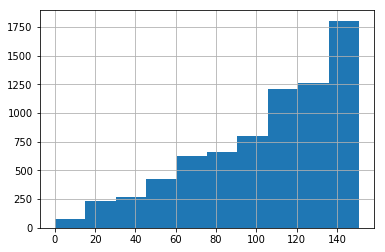

In [6]:
print('max tweet len:',text.map(len).max())
print('min tweet len:',text.map(len).min())
text.map(len).hist();


Use only tweets of over 60 chars

In [7]:
text = text[text.map(len)>60]
len(text)

6366

# Get Chars Dictionary

In [8]:
chars = sorted(list(set(''.join(text))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


total chars: 78


### Inspect Chars

In [9]:
chars

[' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 '@',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 'ʉ',
 '̱',
 'ω',
 'я',
 'ӕ',
 'ԍ',
 'ԏ',
 'ԡ',
 'լ',
 'ջ',
 'ُ',
 '٪',
 '\u06dd',
 'ۢ',
 '۪']

maybe last ones are emojis?  
Let's take a look at sentences with the weird chars.

In [10]:
for c in chars[-19:]:
    print('\nCHAR:', c)
    smple = [x for x in text if c in x]
    print(random.sample(smple,min(3,len(smple))))


CHAR: {
['"{crooked hillary clinton} created this mess, and she knows it." #draintheswamp']

CHAR: |
['"@redletter99: trump pummels his opponents - and the press | sunherald @realdonaldtrump thank you!', 'rt @danscavino: 2016 gop primary hp tracking 139 polls | 28 pollsters. #1 trump 24.1% #2 bush 10.7% #3 carson 8.6% #4 rubio 6.8%', 'join me in florida tomorrow! #makeamericagreatagain daytona | 3pm- jacksonville | 7pm-']

CHAR: }
['"{crooked hillary clinton} created this mess, and she knows it." #draintheswamp']

CHAR: ~
['join me in roanoke, virginia tomorrow at the berglund center- coliseum ~ 6pm! tickets available at:_', 'rt @danscavino: #icymi ~ double digit #gop leader @realdonaldtrumps ۢ speech today in #iowa _ #1 trump @ 28% #2 @s_', '"@destiny: why didnt @seanhannity correct jeb when he said @realdonaldtrump has run 4 president 2x b4~jeb needs 2b corrected b/c he lied."']

CHAR: ʉ
['my pro-growth econ plan: eliminate excessive regulations! lean government! lower taxes! #debat

still weird....  
let's remove them

In [11]:
import re
for c in chars[-19:]:
    text = text.str.replace(c,'')

In [12]:
chars = sorted(list(set(''.join(text))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

chars

total chars: 59


[' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 '@',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

# Create Input Data
input - 40 characters of a tweet  
output - next character  
(make sure we don't combine different tweets into same corpus)

In [13]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 1
sentences = []
next_chars = []
for x in text:
    for i in range(0, len(x) - maxlen, step):
        sentences.append(x[i: i + maxlen])
        next_chars.append(x[i + maxlen])
print('nb sequences:', len(sentences))


nb sequences: 472774


In [14]:
## check example
for i in range(3):
    print(sentences[i],'==>',next_chars[i])

today we express our deepest gratitude t ==> o
oday we express our deepest gratitude to ==>  
day we express our deepest gratitude to  ==> a


In [15]:
text[0]

'today we express our deepest gratitude to all those who have served in our armed forces. #thankavet'

# Vectorization
1. Turn X into matrix of (numer_of_sentences,max_len_of_sentence,num_chars).  
If char i is number j char in sentence k, there will be a 1 in location (k,j,i)
2. Turn y into a vector of (number_of_sentences,num_chars).  
If character z is the next character in sentence k, there will be a 1 in locaiton (k,z)

In [16]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


Vectorization...


<a id='2'></a>
# build the model: a single LSTM
1. Define we have a sequential model
2. Add an LSTM layer with 128 units. Input shape is a matrix of `maxlen` characters, where each character is a vector of `len(chars)`
3. Add a dense layer (fully connected layer) and have the softmax activation pick a winner from the `len(chars)` possible characters.
4. Pick an optimizer for the network and choose `categorical_crossentropy` loss function (used in multiclass classification).

In [17]:
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

# optimizer = RMSprop(lr=0.01)
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


Build model...
Instructions for updating:
Colocations handled automatically by placer.


# Sampler
We don't want the next character to be the one with the highest probaility (we'll get the same results every time).  
So we sample with temperature parameter

In [18]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


example of what the function does:

In [19]:
for temperature in [0.1, 0.2, 0.3,  0.5, 1.0, 1.2, 1.3]:
    print(sample([.1,.3,.5,.1],temperature=temperature))

2
2
2
2
1
2
3


We gave the function an array where highest probability was index number 2 (.5).  
When temperature was low, we got what we expected.  
As we increased the temperature, the function got more creative license choosing the max.  
So:
* temperature helps us not get the same text generated every time
* low temperature = text similar to trained data
* high temperature = more creative generation
* too high temperature = nonsense.

# Generate Text at Epoch End

In [20]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
#     start_index = random.randint(0, len(text) - maxlen - 1)
    tweet = np.random.choice(text) # select random tweet
    start_index = 0

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = tweet[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(120):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


In [21]:
epochs = 5

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])


Instructions for updating:
Use tf.cast instead.
Epoch 1/5
472774/472774 [==============================] - 212s 448us/step - loss: 2.3554

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "join me tomorrow! #trump2016 #makeameric"
join me tomorrow! #trump2016 #makeamericagreatagain #trump2016 #trump2016 #trump2016 #trump2016 #trump2016 #trump2016 #trump2016 #trump2016 #trump2016 #trump201
----- diversity: 0.5
----- Generating with seed: "join me tomorrow! #trump2016 #makeameric"
join me tomorrow! #trump2016 #makeamericagreatagain! #trump2016 #trump2016 #trump2016 #trump2016 #trump2016 #trump2016 #trump2016 #gringater the mall and ijont 
----- diversity: 1.0
----- Generating with seed: "join me tomorrow! #trump2016 #makeameric"
join me tomorrow! #trump2016 #makeamericagreasagain" jo the patee: ox ane inatre tha4 gin the un butc. gom! w/ @pealdorumpatari, by. to heveren on fur fiow lovi
----- diversity: 1.2
----- Generating with seed: "join me tomorro

<a id='3'></a>
# Can we get better results on a bigger network?
* Add epochs for better model
* Add another LSTM layer and dropouts to avoid overfitting.  
* Make sure to set `return_sequences` to True on the first LSTM layer so it will return the entire sequence not just the last output


In [22]:
print('Build model...')
model2 = Sequential()
model2.add(LSTM(128, input_shape=(maxlen, len(chars)),return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128))
model2.add(Dropout(0.2))
model2.add(Dense(len(chars), activation='softmax'))

# optimizer = RMSprop(lr=0.01)
optimizer = Adam()
model2.compile(loss='categorical_crossentropy', optimizer=optimizer)


Build model...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
epochs = 60

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model2.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])


Epoch 1/60
472774/472774 [==============================] - 408s 863us/step - loss: 2.2799

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "big wins in west virginia and nebraska. "
big wins in west virginia and nebraska. #trump2016 #trump2016 #trump2016 #trump2016 #makeamericagreatagain #trump2016 #makeamericagreatagain #trump2016 #trump20
----- diversity: 0.5
----- Generating with seed: "big wins in west virginia and nebraska. "
big wins in west virginia and nebraska. #trump2016 #makeamericagreatagain #trump2016 #trump2016" the gop ratings on illegal will for the republican leader stall
----- diversity: 1.0
----- Generating with seed: "big wins in west virginia and nebraska. "
big wins in west virginia and nebraska. hellar. @denderjubines @aresilway2016" 11/149 8ly the antthert my wonts $5:00. i joth prioblemp wears! jodrelowiesedn- a
----- diversity: 1.2
----- Generating with seed: "big wins in west virginia and nebraska. "
big wins in west vir

# Print Test Sentence

In [24]:
def generate_w_seed(sentence,diversity):
    sentence = sentence[0:maxlen]
    print(f'seed: {sentence}')
    print(f'diversity: {diversity}')
    generated = ''
    generated += sentence
    
    sys.stdout.write(generated)

    for i in range(120):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()
    return

In [25]:
for s in random.sample(list(text),5):
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        generate_w_seed(s,diversity)
        print()

seed: .@hillaryclinton - obama #isis strategy 
diversity: 0.2
.@hillaryclinton - obama #isis strategy the was the people who will be angreating to the polls for the problem the promering the people who want to want to want

seed: .@hillaryclinton - obama #isis strategy 
diversity: 0.5
.@hillaryclinton - obama #isis strategy about endorsement was not reports on @realdonaldtrump the will be bought him borkent states and show beat the because th

seed: .@hillaryclinton - obama #isis strategy 
diversity: 1.0
.@hillaryclinton - obama #isis strategy trump" therpe play new lease not but the they my up 7:002 - fasiderd alropee? #trump2016 clooken for strand way in prist

seed: .@hillaryclinton - obama #isis strategy 
diversity: 1.2
.@hillaryclinton - obama #isis strategy are bigweral/as carey the was big! exsiar! i reounty she he is?mil" be that when aiscevinters--uestachoo,smorviews. @dbu

seed: i had a great time in texas yesterday. a
diversity: 0.2
i had a great time in texas yesterday. and

# TODO

Well, the model is not perfect, but this was a quick baseline model.  
Things that can help with this and any other LSTM
* adding more data (Kaggle has more Trumpian corpus that can help train our generator)
* increase the network size
* train longer
* use more sophisticated architecture